In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
import matplotlib
sb.set() # set the default Seaborn style for graphics
import os
import geopandas as gpd

Dataset from https://www.kaggle.com/datasets/omkargowda/suicide-rates-overview-1985-to-2021 (Suicide Data) and<br>
https://www.kaggle.com/datasets/andradaolteanu/country-mapping-iso-continent-region (Country++ Information)

# Goal of this project

Find out what affects suicide rate the most and thus be able to allocate resources to those factors more helpful in lowering suicide rates. We will compare between 3 models, decision tree, random forest and XGBoost to see which is more accurate, and thus the better model to predict who needs more help. 


# Data Cleaning

Using excel - removed unnecessary columns in continent2.csv 

In [2]:
SuicideData = pd.read_csv("master.csv",low_memory=False)
regionalData = pd.read_csv("continents2.csv",low_memory=False)

In [3]:
SuicideData.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21.0,312900,6.71,Albania1987,NaN,"2,15,66,24,900",796.0,Generation X
1,Albania,1987,male,35-54 years,16.0,308000,5.19,Albania1987,NaN,"2,15,66,24,900",796.0,Silent
2,Albania,1987,female,15-24 years,14.0,289700,4.83,Albania1987,NaN,"2,15,66,24,900",796.0,Generation X
3,Albania,1987,male,75+ years,1.0,21800,4.59,Albania1987,NaN,"2,15,66,24,900",796.0,G.I. Generation
4,Albania,1987,male,25-34 years,9.0,274300,3.28,Albania1987,NaN,"2,15,66,24,900",796.0,Boomers


In [4]:
regionalData.head()

,name,region,sub-region,Unnamed: 3,alpha-3
0,Afghanistan,Asia,Southern Asia,NaN,AFG
1,Åland Islands,Europe,Northern Europe,NaN,ALA
2,Albania,Europe,Southern Europe,NaN,ALB
3,Algeria,Africa,Northern Africa,NaN,DZA
4,American Samoa,Oceania,Polynesia,NaN,ASM


Drop the unnecessary columns in regionalData dataframe

In [5]:
# drop the 3 uneeded columns in regionalData
regionalData.drop(axis=1, columns=['Unnamed: 3', 'alpha-3', 'sub-region'], inplace=True)
regionalData = regionalData.reset_index(drop=True)


Rename the column names so that we can join them later on, and also for easier access(cleaner names)

In [6]:
# renaming column names for easier access, and for joining/merging dataframes

SuicideData.rename({'gdp_per_capita ($)' : 'gdp_per_capita', 'suicides/100k pop':'suicides/100k_pop' }, axis=1, inplace = True)
regionalData.rename({'name' : 'country'}, axis=1, inplace = True)

Now we merge the 2 datasets, so that we have a region attached to the country.

In [7]:
# Merge the 2 datasets to include region
SuicideData = pd.merge(SuicideData , regionalData, how='left', on ='country')

# Show columns/dtypes for SD(check changes and datatypes)
SuicideData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31756 entries, 0 to 31755
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             31756 non-null  object 
 1   year                31756 non-null  int64  
 2   sex                 31756 non-null  object 
 3   age                 31756 non-null  object 
 4   suicides_no         30556 non-null  float64
 5   population          31756 non-null  int64  
 6   suicides/100k_pop   31756 non-null  float64
 7   country-year        31756 non-null  object 
 8   HDI for year        12300 non-null  float64
 9    gdp_for_year ($)   31756 non-null  object 
 10  gdp_per_capita      31756 non-null  float64
 11  generation          31756 non-null  object 
 12  region              30388 non-null  object 
dtypes: float64(4), int64(2), object(7)
memory usage: 3.4+ MB


Cleaning the data. <br>
We remove all countries with no suicides reported, and we also drop HDI per year along with its associated column country-year as values are largely NaN.<br>
We also remove years after 2016 as data is erroneous - population figures are inaccurate.

In [8]:
# check Nan Values
SuicideData.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no            1200
population                0
suicides/100k_pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita            0
generation                0
region                 1368
dtype: int64

In [9]:
# Find NaN fields and clean dataset - countires with suicide/population not reported - removed 
# Data after 2016(2017 onwards) is erronneous - all will be removed
# We also drop HDI per year along with its associated column country-year as values are largely NaN.

SuicideData.dropna(subset = ['suicides_no'], inplace=True)
SuicideData.drop(axis=1, columns=['HDI for year', 'country-year'], inplace=True)
SuicideData = SuicideData[SuicideData.year != 2017]
SuicideData = SuicideData[SuicideData.year != 2018]
SuicideData = SuicideData[SuicideData.year != 2019]
SuicideData = SuicideData[SuicideData.year != 2020]

#reset index after cleaning
SuicideData = SuicideData.reset_index(drop=True)

Now, initialise worldmap dataset from geopandas, for EDA later on.

In [10]:
# initialising world map, changing name(country) column to match suicidedata

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world.rename({'name' : 'country'}, axis=1, inplace = True)


In [11]:
world.head()

,pop_est,continent,country,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."


Look at missing countries not in both datasets, check if same country exist under a different name

In [12]:
SDcountry_data = list(SuicideData['country'].unique())

country_geo = list(world['country'])

# look through missing countries
country_diff = [country for country in SDcountry_data if country not in country_geo]

print(country_diff)


['Antigua and Barbuda', 'Aruba', 'Bahrain', 'Barbados', 'Bosnia and Herzegovina', 'Cabo Verde', 'Czech Republic', 'Dominica', 'Grenada', 'Kiribati', 'Macau', 'Maldives', 'Malta', 'Mauritius', 'Republic of Korea', 'Russian Federation', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and Grenadines', 'San Marino', 'Seychelles', 'Singapore', 'United States']


In [13]:
# countries names in country geodata, check if same country exist under a different name
country_geo

['Fiji',
 'Tanzania',
 'W. Sahara',
 'Canada',
 'United States of America',
 'Kazakhstan',
 'Uzbekistan',
 'Papua New Guinea',
 'Indonesia',
 'Argentina',
 'Chile',
 'Dem. Rep. Congo',
 'Somalia',
 'Kenya',
 'Sudan',
 'Chad',
 'Haiti',
 'Dominican Rep.',
 'Russia',
 'Bahamas',
 'Falkland Is.',
 'Norway',
 'Greenland',
 'Fr. S. Antarctic Lands',
 'Timor-Leste',
 'South Africa',
 'Lesotho',
 'Mexico',
 'Uruguay',
 'Brazil',
 'Bolivia',
 'Peru',
 'Colombia',
 'Panama',
 'Costa Rica',
 'Nicaragua',
 'Honduras',
 'El Salvador',
 'Guatemala',
 'Belize',
 'Venezuela',
 'Guyana',
 'Suriname',
 'France',
 'Ecuador',
 'Puerto Rico',
 'Jamaica',
 'Cuba',
 'Zimbabwe',
 'Botswana',
 'Namibia',
 'Senegal',
 'Mali',
 'Mauritania',
 'Benin',
 'Niger',
 'Nigeria',
 'Cameroon',
 'Togo',
 'Ghana',
 "Côte d'Ivoire",
 'Guinea',
 'Guinea-Bissau',
 'Liberia',
 'Sierra Leone',
 'Burkina Faso',
 'Central African Rep.',
 'Congo',
 'Gabon',
 'Eq. Guinea',
 'Zambia',
 'Malawi',
 'Mozambique',
 'eSwatini',
 'Angol

Some coutries have different names on geocountry data, change them so they match for merging datasets later.

In [14]:
# Replace countries with differing names 
SuicideData['country'].replace({'Russian Federation' : 'Russia', 'Republic of Korea': 'South Korea',
                                'Czech Republic' : 'Czechia', 'Bosnia and Herzegovina' : 'Bosnia and Herz.',
                                'Dominican Republic' : 'Dominican Rep.','United States' : 'United States of America',
                                'Brunei Darussalam' : 'Brunei', 'China, Hong Kong SAR' : 'China', 
                                'Republic of Moldova' : 'Moldova',
                                'Saint Vincent and the Grenadines' : 'Saint Vincent and Grenadines'}, inplace = True)


In [15]:
# a peek at SuicideData after cleaning
SuicideData.head()

,country,year,sex,age,suicides_no,population,suicides/100k_pop,gdp_for_year ($),gdp_per_capita,generation,region
0,Albania,1987,male,15-24 years,21.0,312900,6.71,"2,15,66,24,900",796.0,Generation X,Europe
1,Albania,1987,male,35-54 years,16.0,308000,5.19,"2,15,66,24,900",796.0,Silent,Europe
2,Albania,1987,female,15-24 years,14.0,289700,4.83,"2,15,66,24,900",796.0,Generation X,Europe
3,Albania,1987,male,75+ years,1.0,21800,4.59,"2,15,66,24,900",796.0,G.I. Generation,Europe
4,Albania,1987,male,25-34 years,9.0,274300,3.28,"2,15,66,24,900",796.0,Boomers,Europe


In [16]:
SuicideData['country'].describe()
# So we have 101 countries to work with 

count         27820
unique          101
top       Mauritius
freq            382
Name: country, dtype: object

# Exploratory Data Analysis!

As we are mostly concerned with suicide rates, we will be focusing on suicide rates (suicides/100k_pop) against various factors

## Quick look at numeric correlation values

<Axes: >

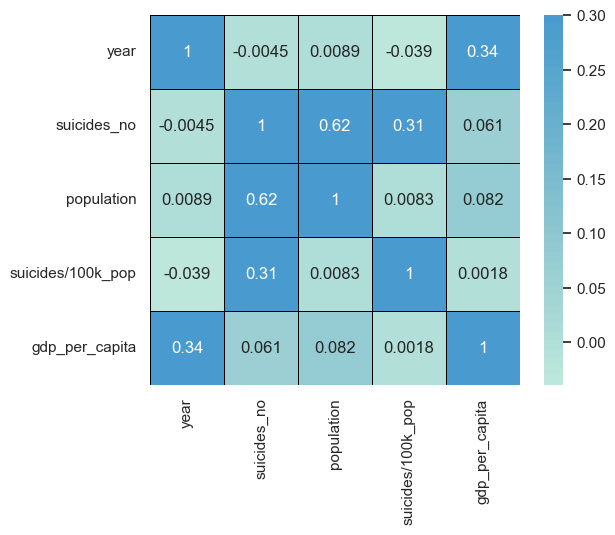

In [17]:
# Better gradient visualisation of heatmap 
sb.heatmap(SuicideData.corr(numeric_only = True), vmax=.3, center=1,
            square=True, linewidths=.5, linecolor = 'black', annot=True)

# Seems like theres not much relation between numeric vairables and suicides/100k_pop
# year and gdp have a positive correlation 

Suicide numbers seems to have a correlation to population, but once normalised to suicides/100k_pop, correlation is non-existent

Theres not much relation between numeric variables and suicides/100k_pop. We ignore suicide numbers for obvious reasons.


## Lets look at overall suicide rates over the years! Is it worsening or getting better?

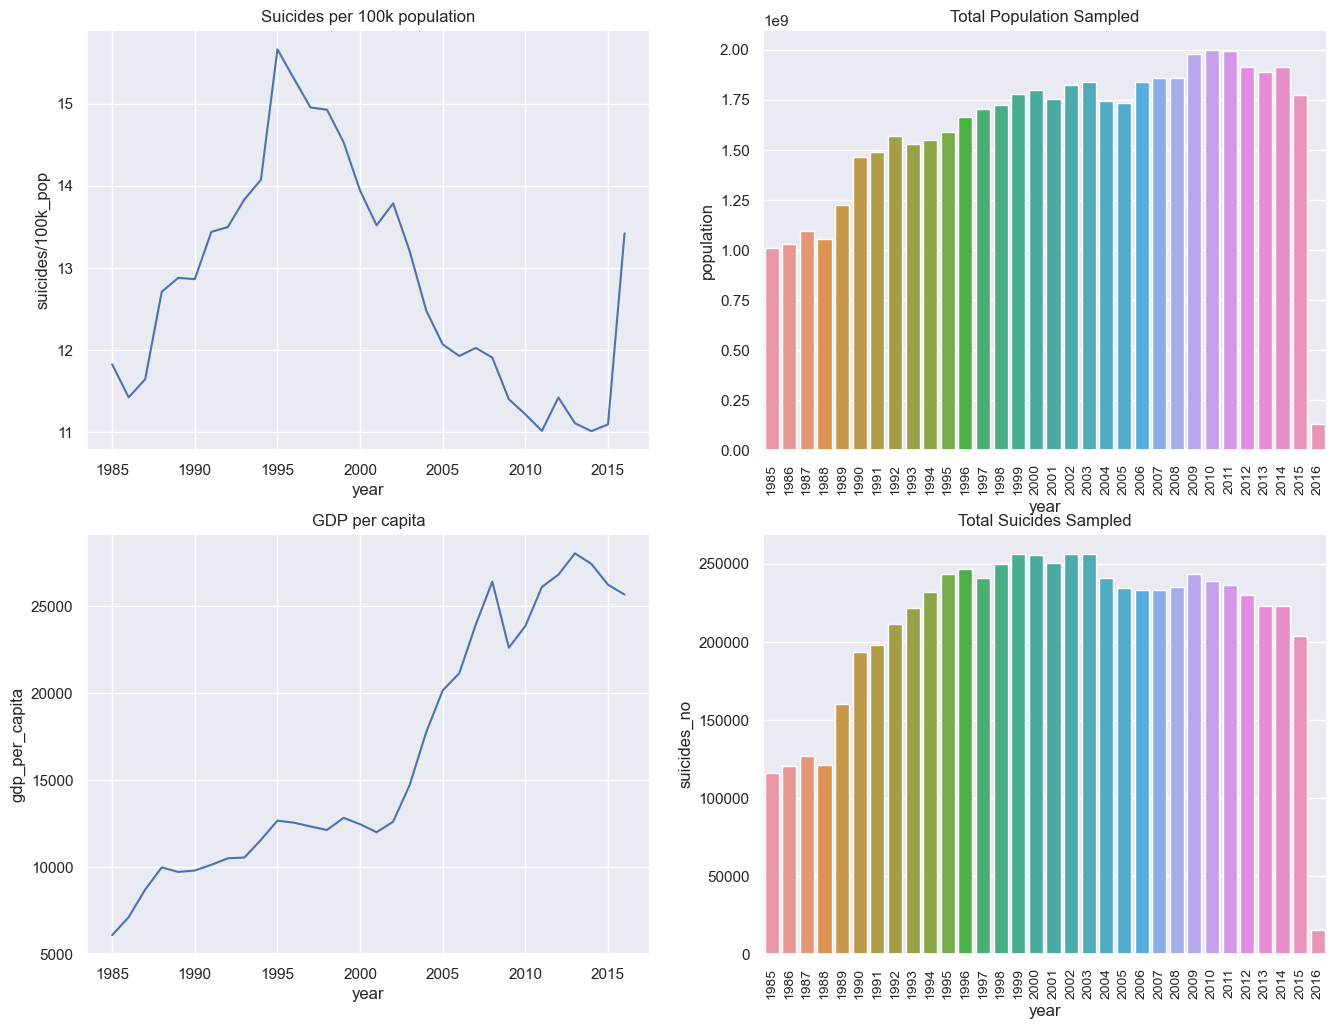

In [18]:
SDyearmean = SuicideData.groupby(["year","country"]).mean(numeric_only = True).reset_index()
SDyearsum = SuicideData.groupby(["year"]).sum(numeric_only = True).reset_index()

f, axes = plt.subplots(2, 2, figsize=(16, 12))

sb.lineplot(data = SDyearmean, x = "year", y = "suicides/100k_pop", errorbar=None,ax=axes[0,0]) #mean
bar2 = sb.barplot(data = SDyearsum, x = "year", y = "population", ax=axes[0,1]) #sum
sb.lineplot(data = SDyearmean, x = "year", y = "gdp_per_capita",errorbar=None, ax=axes[1,0]) #mean
bar4 = sb.barplot(data = SDyearsum, x = "year", y = "suicides_no", ax=axes[1,1]) #sum


axes[0,0].set_title('Suicides per 100k population')
axes[0,1].set_title('Total Population Sampled')
axes[0,1].tick_params(axis='x', which='major', labelsize=10)
bar2.set_xticklabels(bar2.get_xticklabels(), rotation=90)
axes[1,0].set_title('GDP per capita')
axes[1,1].set_title('Total Suicides Sampled')
bar4.set_xticklabels(bar4.get_xticklabels(), rotation=90)
axes[1,1].tick_params(axis='x', which='major', labelsize=10)

1985 - 1995 increasing trend of suicide rates.
Since 1995, suicide rates has been decreasing over the years! A good sign. 
However a spike in 2016 can be observed.

Looking against the population and suicides sample, it is way smaller in 2016. Thus the data is likely to be more biased - not representative of the wider world.

Again, just to reiterate, sums are not accurate in representation! Countries included differ between years.

# Exploring categorical variables


## Age! Is age related to suicide rates?<br>
Age in this data set is categorized into groups.<br>

5-14 Years - Generation Z<br>
15-24 Years - Millenials<br>
25-34 Years - Generation X<br>
35-54 Years - Boomers<br>
55-74 Years - Silent<br>
75++ Years - G.I. Generation<br>


Text(0.5, 1.0, 'Population sampled')

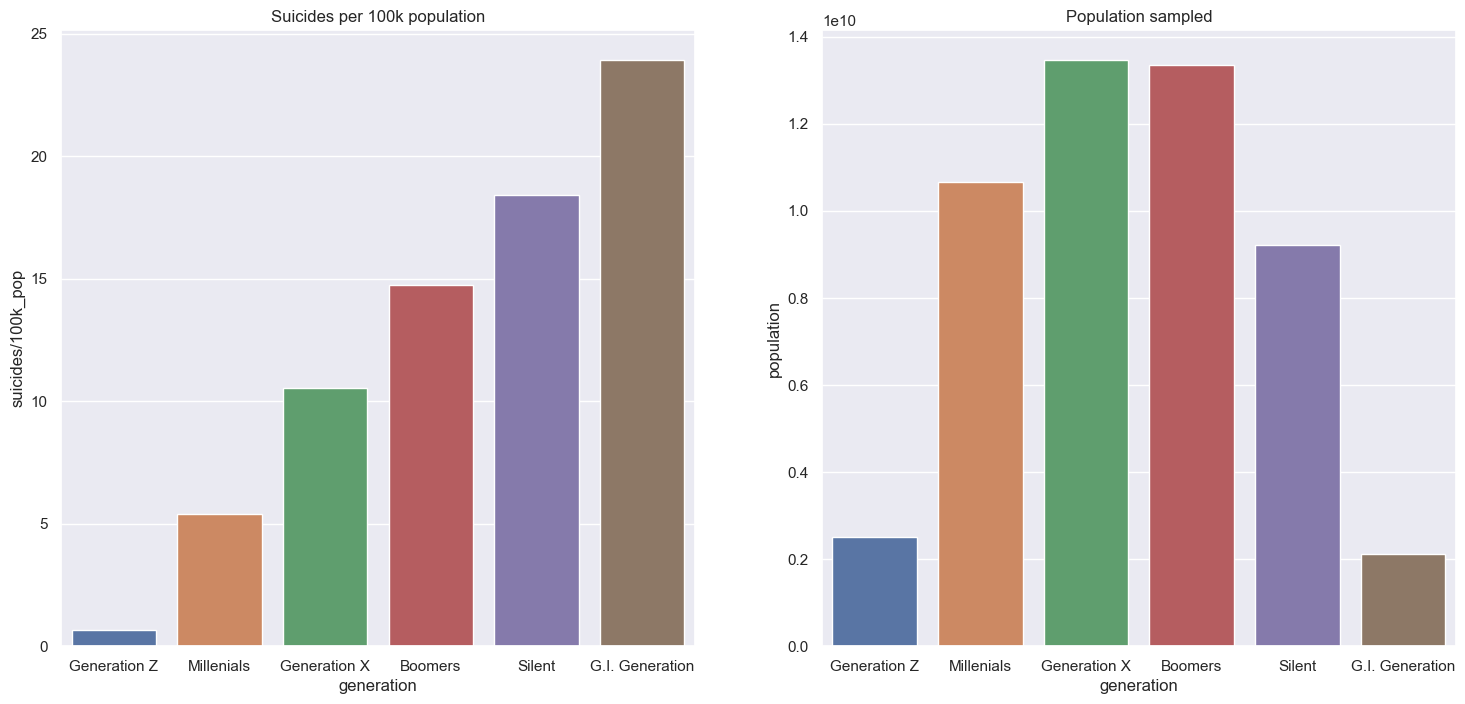

In [19]:
# Explore Age!
SDagemean = SuicideData.groupby(["generation"]).mean(numeric_only = True).reset_index()
SDagesum = SuicideData.groupby(["generation"]).sum(numeric_only = True).reset_index()

f, axes = plt.subplots(1,2, figsize=(18, 8))

ageavg = sb.barplot(data = SDagemean, x = 'generation', y ="suicides/100k_pop", order = SDagemean.sort_values('suicides/100k_pop').generation, ax = axes[0])
agesum = sb.barplot(data = SDagesum, x = 'generation', y ="population", order = SDagemean.sort_values('suicides/100k_pop').generation, ax = axes[1])

axes[0].set_title('Suicides per 100k population')
axes[1].set_title('Population sampled')


Seems like age is largely related to suicide rates - the older generations have a higher tendency to suicide.

Sample size seen on the right - sample sizes are large, no bias.(we use rate so sample size does not matter unless its small)

<Axes: xlabel='year', ylabel='suicides/100k_pop'>

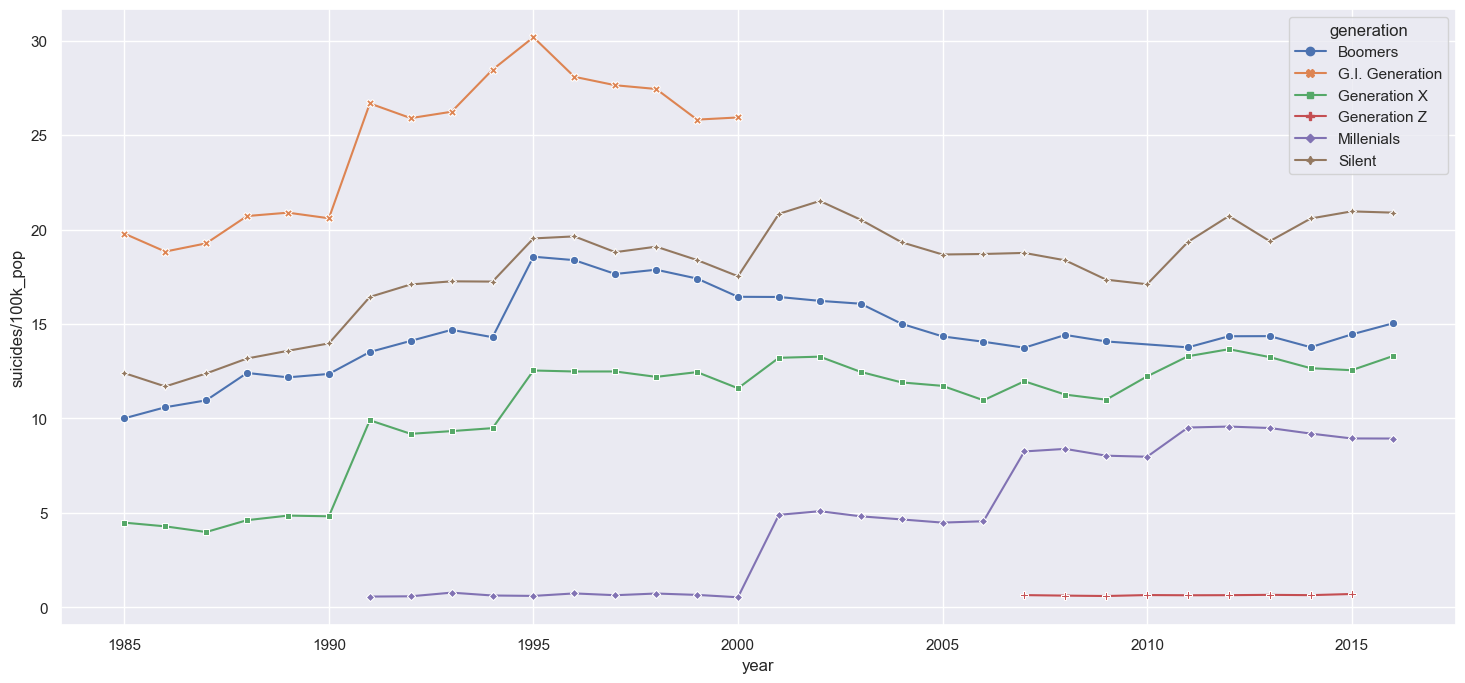

In [20]:
# what about over the years comparison?

f = plt.subplots(figsize=(18, 8))

SDgenyearmean = SuicideData.groupby(["generation","year"]).mean(numeric_only = True).reset_index()
sb.lineplot(data = SDgenyearmean, x = 'year', y = 'suicides/100k_pop', hue = 'generation', style = 'generation', markers = True, dashes = False)


Trend observed. Older = more likely of suicide. Younger = less likely of suicide. <br>
Younger people tend to not suicide. Understandable as kids do not normally think of suicide, only after a certain age does it become a more conscious thought.(notice the spike in millenials chart, and the low(flat) gen z line)

## Sex! Does Gender matter?
We have 2 genders - Male and Female 

Text(0.5, 1.0, 'Total Population Sampled')

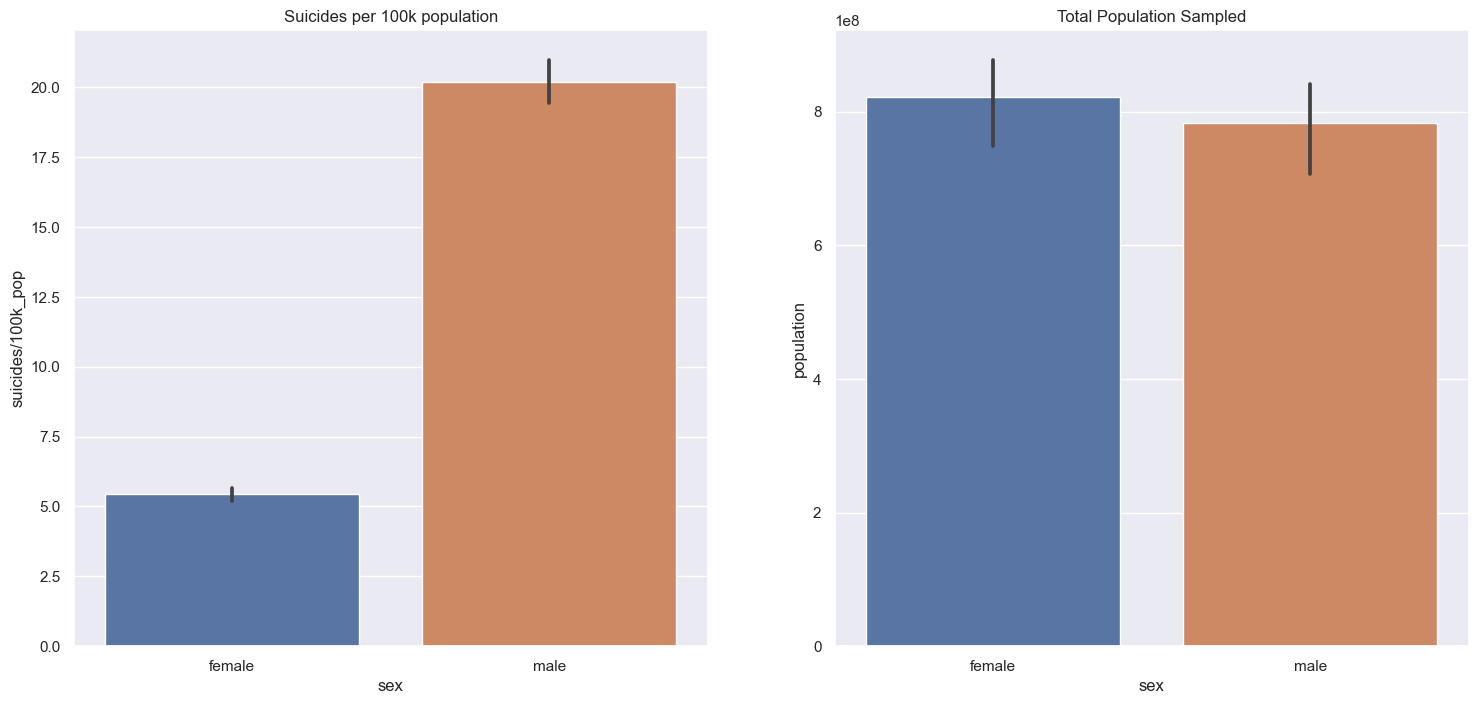

In [21]:
# Explore Sex!

SDsexmean = SuicideData.groupby(["sex","year"]).mean(numeric_only = True).reset_index()
SDsexsum = SuicideData.groupby(["sex","year"]).sum(numeric_only = True).reset_index()

f, axes = plt.subplots(1,2, figsize=(18, 8))

sexmean = sb.barplot(data = SDsexmean, x = 'sex', y ="suicides/100k_pop", ax = axes[0])
sexsum = sb.barplot(data = SDsexsum, x = 'sex', y ="population", ax = axes[1])

axes[0].set_title('Suicides per 100k population')
axes[1].set_title('Total Population Sampled')



Males are significantly more likely to suicide - sample sizes are relatively equal, there are no noticible biases.
Seems like a significant trend - gender heavily related to suicide rates!

Possible explanations would be disproportionate men having to fight wars,resulting in PTSD. And also societal outlook on men masculinity.

Lets explore this trend over the years - is it consistent?

<Axes: xlabel='year', ylabel='suicides/100k_pop'>

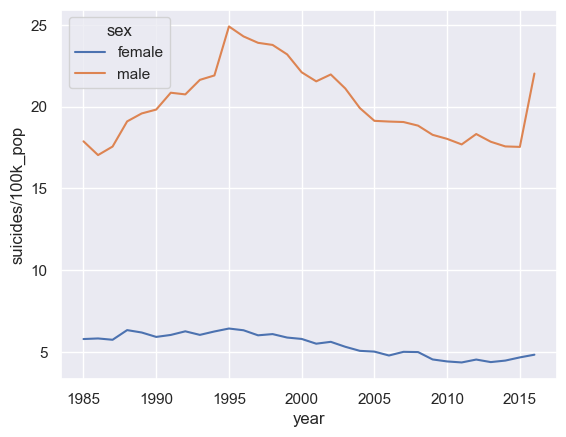

In [22]:
sb.lineplot(data = SDsexmean, x = 'year', y = "suicides/100k_pop", hue = 'sex')

# Country and region!

How many countries in each region are there in our dataset?

<Axes: xlabel='region', ylabel='count'>

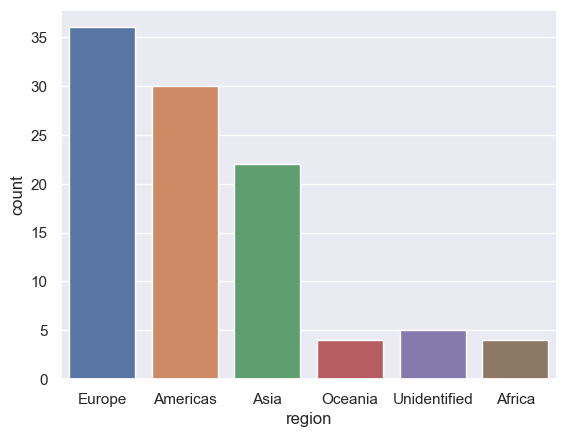

In [23]:
#NA means unclassified region
SuicideData['region'] = SuicideData['region'].fillna('Unidentified')
# consolidate into countries
SDcountrymean = SuicideData.groupby(["country","region"]).mean(numeric_only = True).reset_index()

sb.countplot(data = SDcountrymean, x = 'region')

#shown distribution of countries in respective regions

<Axes: xlabel='suicides/100k_pop', ylabel='country'>

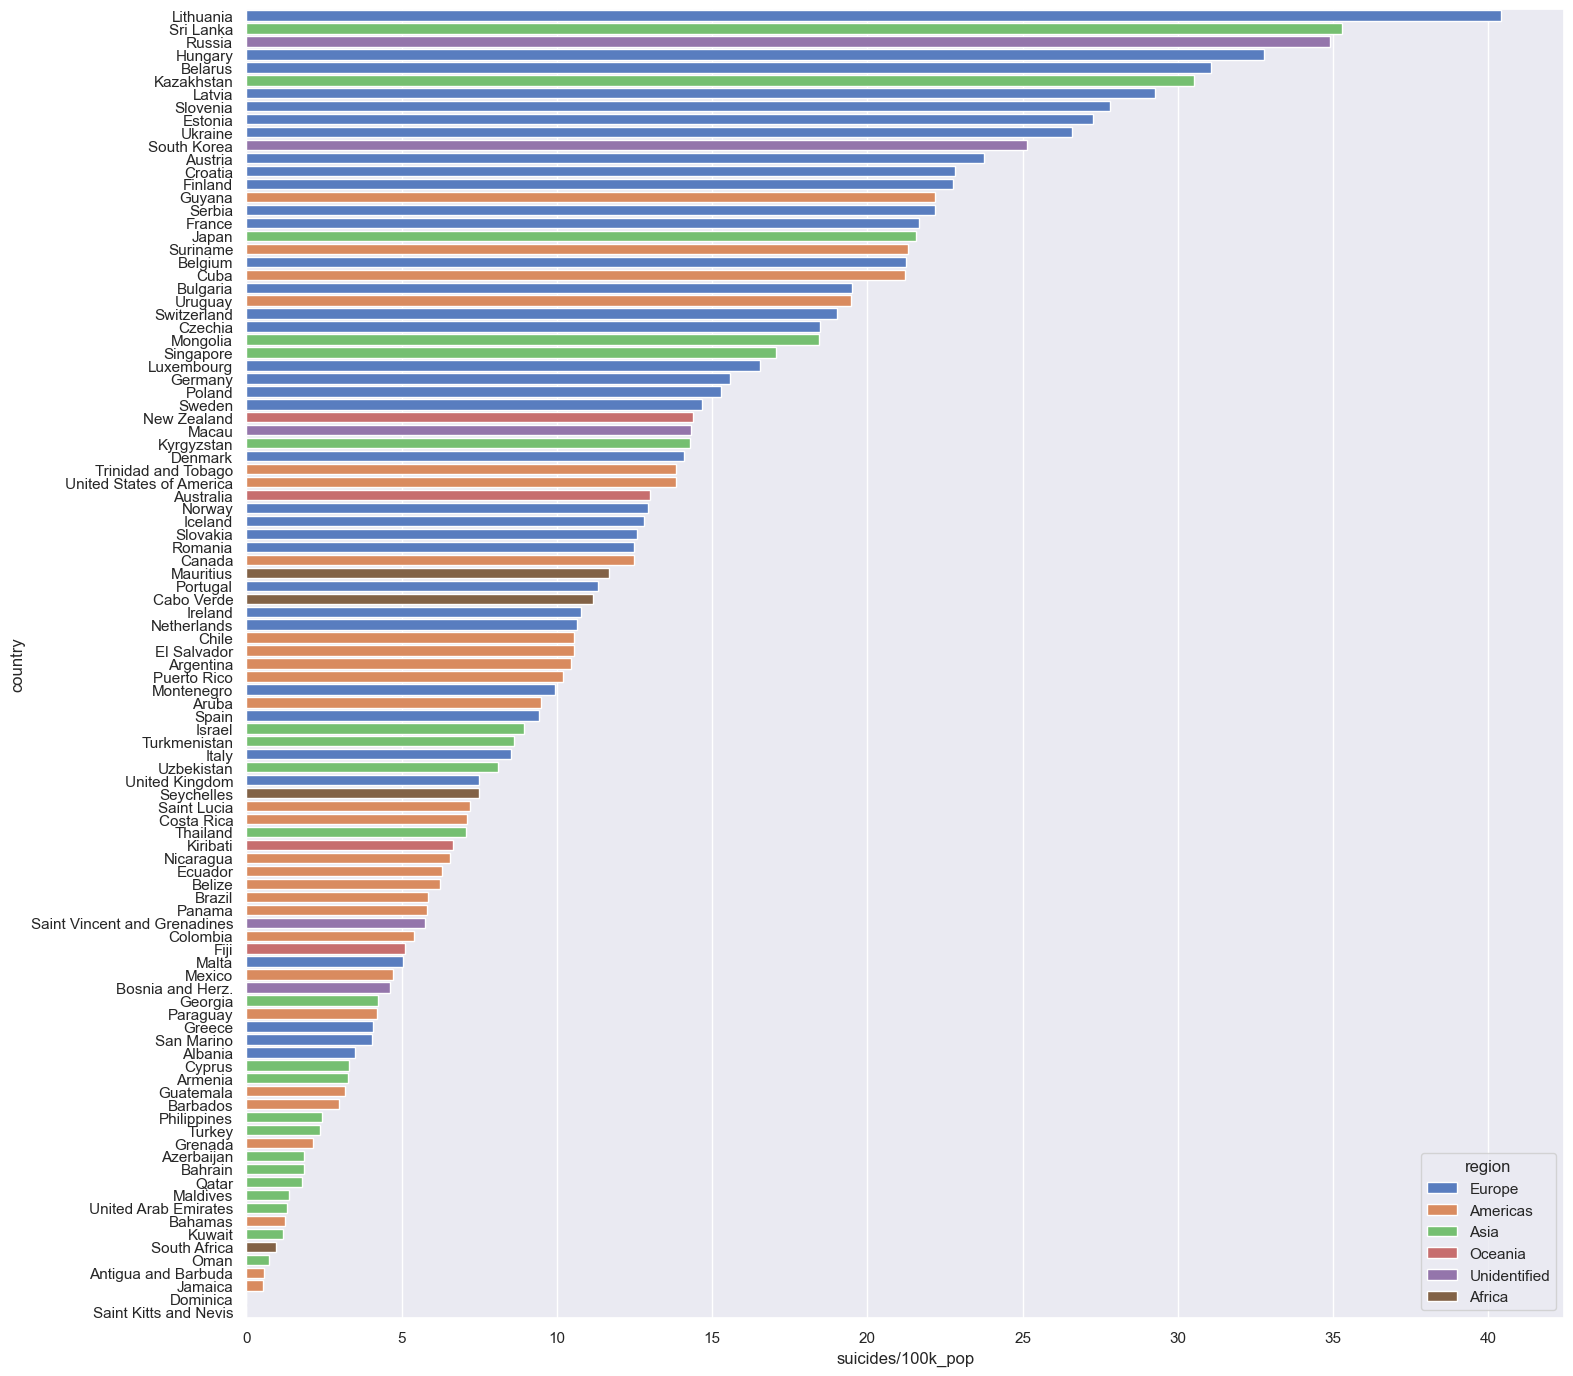

In [24]:
SDcountrymean = SuicideData.groupby(["country","region"]).mean(numeric_only = True).reset_index()

fig, ax = plt.subplots(figsize=(17, 17))

sb.barplot(data = SDcountrymean, y = 'country', x ="suicides/100k_pop", orient = 'h', hue = 'region', palette = 'muted',
           order = SDcountrymean.sort_values('suicides/100k_pop', ascending = False).country, dodge=False )

From a glance, seems like Europeans have higher suicide rates. <br>
Now, lets visualise the statistics better on the world map using geopandas.

In [25]:
# countries that are in world
mapped = world.join(SDcountrymean.set_index('country'), on='country')

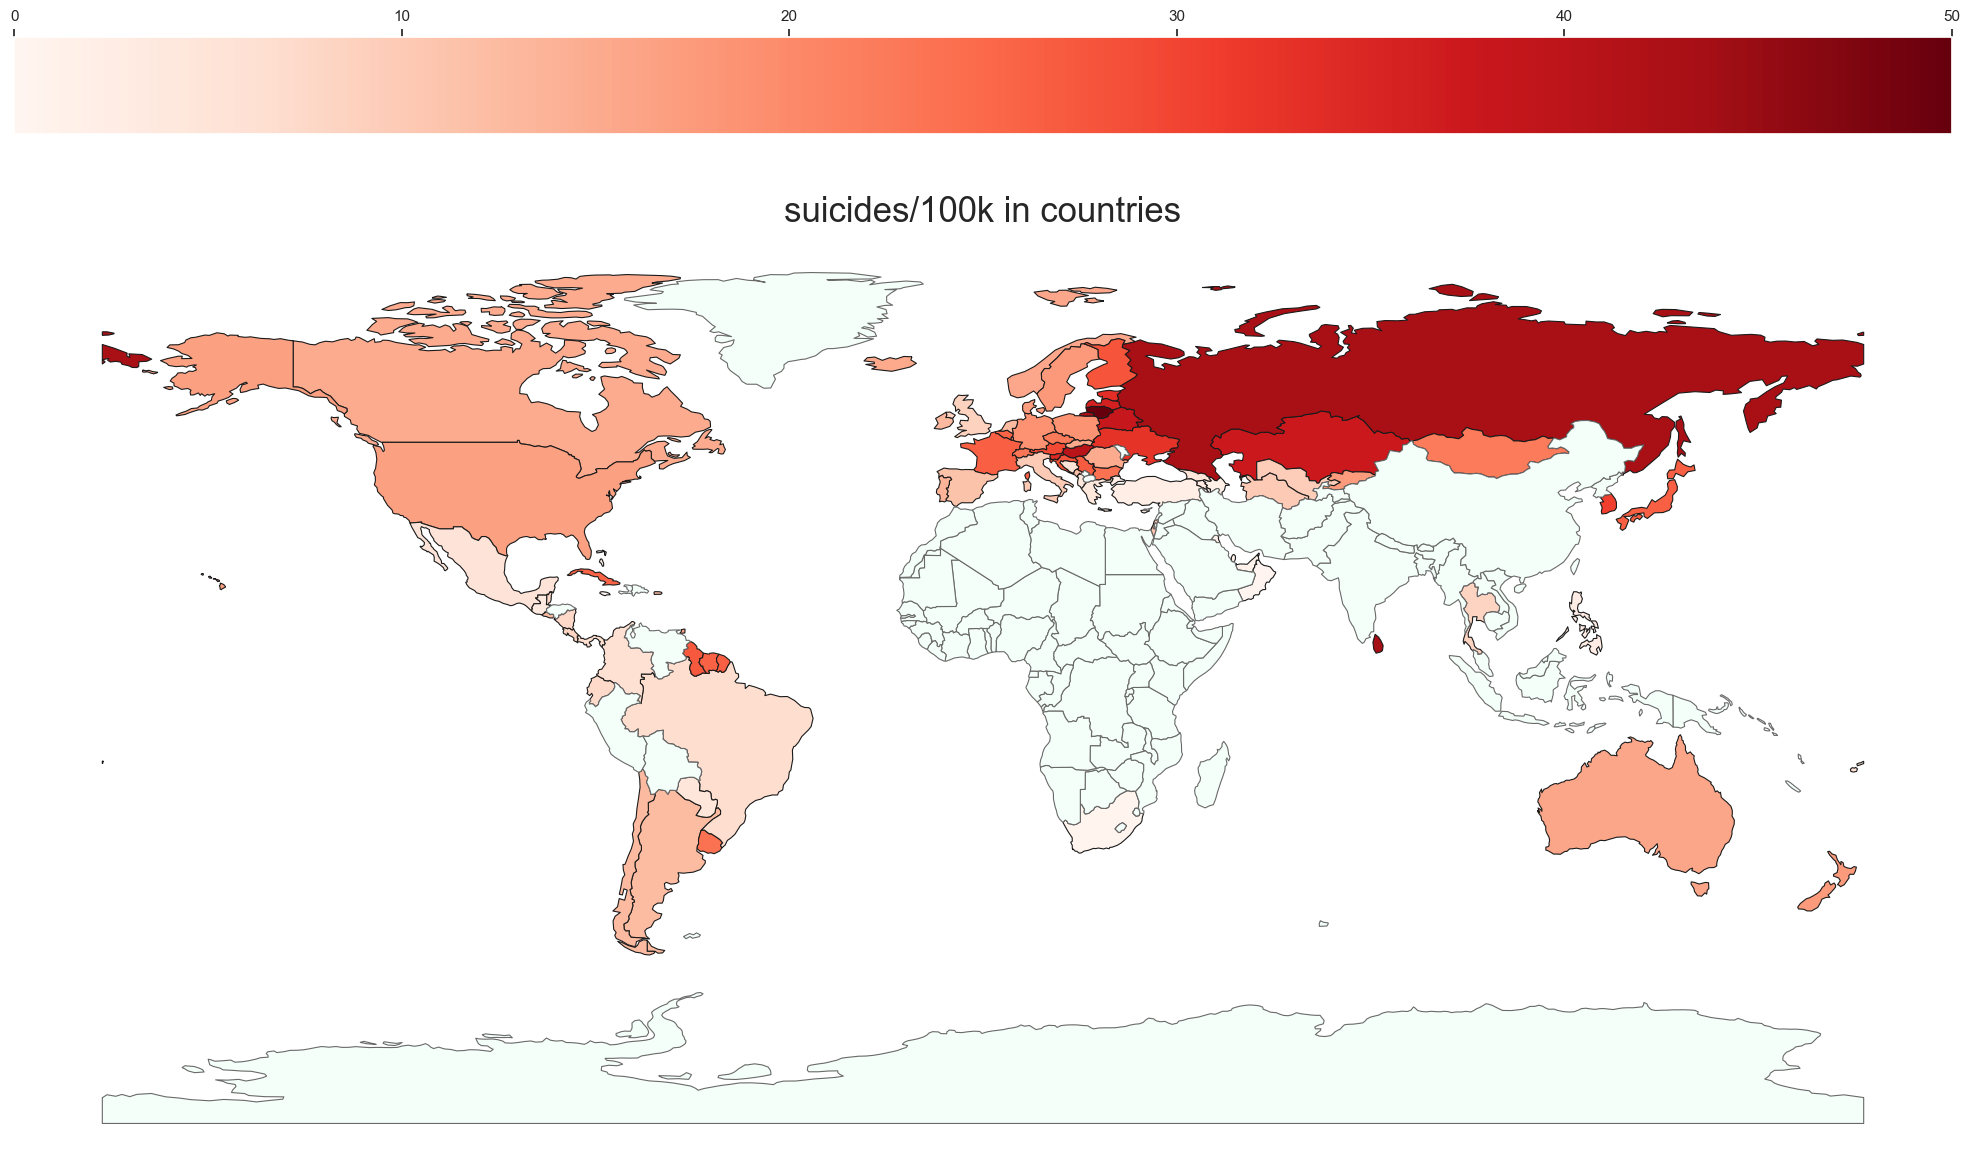

In [26]:
fig, ax = plt.subplots(1, figsize=(25,25))

#0 to 50 since country with highest suicides/100k_pop ~ 40+.
vmin, vmax = 0,50 

mapped.plot(column='suicides/100k_pop', cmap='Reds', linewidth=0.8, ax=ax, edgecolors='0.1', missing_kwds={
        "color": "mintcream", #color wise either white or a contrasting color to emphasize non-participants in scale
        "edgecolor": "dimgrey",
        "label": "Missing values",
    })
ax.set_title('suicides/100k in countries', fontdict={'fontsize' :25})
ax.set_axis_off()

sm = plt.cm.ScalarMappable(cmap='Reds', norm = plt.Normalize(vmin=vmin, vmax=vmax))

cbar = fig.colorbar(mappable = sm, ax=ax, orientation='horizontal', location = 'top')

Most data in the africa, Asia are left out. The model we use later cannot be generalised to include these countries.

# GDP per Capita
Does money relate to suicide rates?

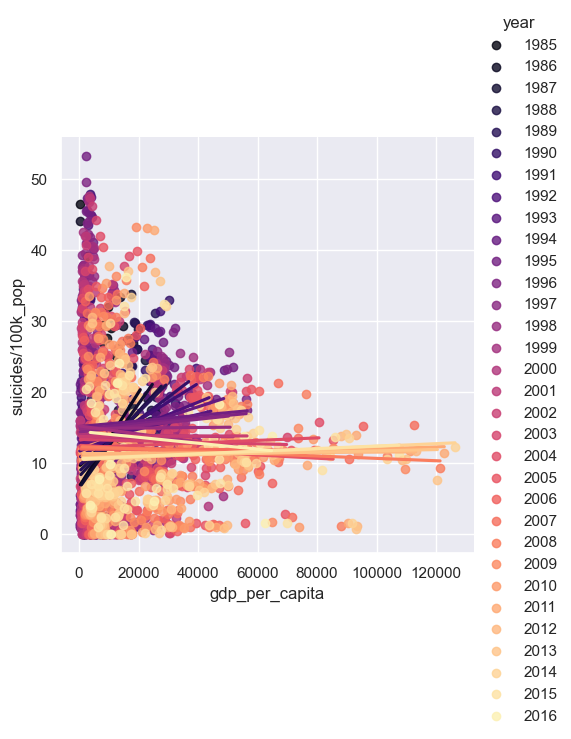

In [27]:
# gdp against suicide100k
SDcountryyearsmean = SuicideData.groupby(["country","year"]).mean(numeric_only = True).reset_index()
sb.lmplot(data = SDcountryyearsmean, x = 'gdp_per_capita', y = 'suicides/100k_pop', hue = 'year', palette = 'magma', ci=None)

In earlier years, higher gdp per capita has positive correlation with suicides/100k. higher gdp = higher suicide rates.<br>
But correlation weakens in later years. <br>
Seems to have no linear correlation overall. (as observed from heatmap)


# So up to now - we notice gender, country/region and age has noticible relation with suicides per 100k pop


We will now use and compare 3 models, classification tree, random forest and logistic regression to predict whether a person is likely to suicide.<br>

We will create a new variable - high and low suicide risk. A person is of high suicide risk if suicide rate in his country, age group etc. is higher than the mean, else low.<br>

This way, we are able to categorize better those who needs help and those who dont.


# Classification Tree, Random Forest and XGBoost!

Find out which categorical factors are most linked to suicide, and find best model able to predict accurately.



## Creating new categorical variable - suicide risk 
Also create a copy of SuicideData for further use, removing unecessary columns for modelling purposes.<br>
gdpforyear -- we have gdppercapita<br>
suicide numbers, population -- we have suicides/100k<br>
generation -- we have age<br>
year -- we are predicting a future case, year is not to be used as a variable as we do not use date as feature

In [35]:
# Create additional column for suicide risk and set the default value as 0(low)
SuicideData['suicide_risk'] = 0
# Set the risk as 1(high) if suicides/100k pop is higher than the mean
SuicideData.loc[SuicideData['suicides/100k_pop'] > SuicideData['suicides/100k_pop'].mean(), 'suicide_risk'] = 1
SuicideData['suicide_risk'].value_counts()

0    19061
1     8759
Name: suicide_risk, dtype: int64

In [36]:
# drop unnecessary data - we have gdp per capita and suicides/100k, age, and suicide risk. 
# Year dropped as we are predicting the future, thus is not to be a correlation var.
SuicideData_Model = pd.DataFrame(SuicideData)
SuicideData_Model.drop([' gdp_for_year ($) ','suicides_no','population','generation','suicides/100k_pop','year'],
                       axis = 1, inplace = True)

# Classification/Decision Tree & Some Data Pre-processing

Split dataset into 8:2 Train and Test datasets for modelling the classification tree.(to avoid overfitting)<br>

#### gdp_per_capita is also normalised to a scale from 0-1 so it minimizes possible influence on the algorithm with smaller values.

#### We do one-hot encoding on all the categorical variables (using sklearn MinMaxScaler) - to convert it into numerical variables. Helps with machine learning algorithms, as it treats the variables as equals, with all values having no precedence over the other.



In [37]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler


#scale the numerical variable gdppercapita to a scale of 0 to 1 
scaler = MinMaxScaler()
SuicideData_Model['gdp_per_capita'] = scaler.fit_transform(SuicideData_Model[['gdp_per_capita']])

# obtain suicide_risk(target) and dataframe(variables) without it
SuicideRisk = pd.DataFrame(SuicideData_Model['suicide_risk'])
SuicideData_Model.drop(['suicide_risk'], axis = 1, inplace = True)

# now use one-hot encoder on the categorical variables
SuicideData_Model = pd.get_dummies(SuicideData_Model)

In [38]:
# Split the data into training and testing sets , check the shape

train_SuicideData, test_SuicideData, train_SuicideRisk, test_SuicideRisk = train_test_split(SuicideData_Model, SuicideRisk, test_size = 0.2, random_state = 42)
print('Training SuicideData Shape:', train_SuicideData.shape)
print('Training SuicideRisk Shape:', train_SuicideRisk.shape)
print('Testing SuicideData Shape:', test_SuicideData.shape)
print('Testing SuicideRisk Shape:', test_SuicideRisk.shape)

Training SuicideData Shape: (22256, 116)
Training SuicideRisk Shape: (22256, 1)
Testing SuicideData Shape: (5564, 116)
Testing SuicideRisk Shape: (5564, 1)


## Hyperparameter: Choose depth 4 instead of lower or larger numbers to avoid overfitting but still have good/acceptable classification accuracy

In [39]:
from sklearn.tree import DecisionTreeClassifier

# Create a Decision Tree Classifier object
dectree_4train = DecisionTreeClassifier(max_depth = 4, random_state = 42)

dectree_4train.fit(train_SuicideData,train_SuicideRisk)

DecisionTreeClassifier(max_depth=4, random_state=42)

[Text(0.5446428571428571, 0.9, 'sex_male <= 0.5\ngini = 0.433\nsamples = 22256\nvalue = [15214, 7042]\nclass = Low'),
 Text(0.2857142857142857, 0.7, 'age_75+ years <= 0.5\ngini = 0.198\nsamples = 11052\nvalue = [9824, 1228]\nclass = Low'),
 Text(0.14285714285714285, 0.5, 'age_55-74 years <= 0.5\ngini = 0.143\nsamples = 9224\nvalue = [8508, 716]\nclass = Low'),
 Text(0.07142857142857142, 0.3, 'country_Sri Lanka <= 0.5\ngini = 0.085\nsamples = 7378\nvalue = [7049, 329]\nclass = Low'),
 Text(0.03571428571428571, 0.1, 'gini = 0.08\nsamples = 7340\nvalue = [7034, 306]\nclass = Low'),
 Text(0.10714285714285714, 0.1, 'gini = 0.478\nsamples = 38\nvalue = [15, 23]\nclass = High'),
 Text(0.21428571428571427, 0.3, 'region_Europe <= 0.5\ngini = 0.331\nsamples = 1846\nvalue = [1459, 387]\nclass = Low'),
 Text(0.17857142857142858, 0.1, 'gini = 0.189\nsamples = 1104\nvalue = [987, 117]\nclass = Low'),
 Text(0.25, 0.1, 'gini = 0.463\nsamples = 742\nvalue = [472, 270]\nclass = Low'),
 Text(0.4285714285

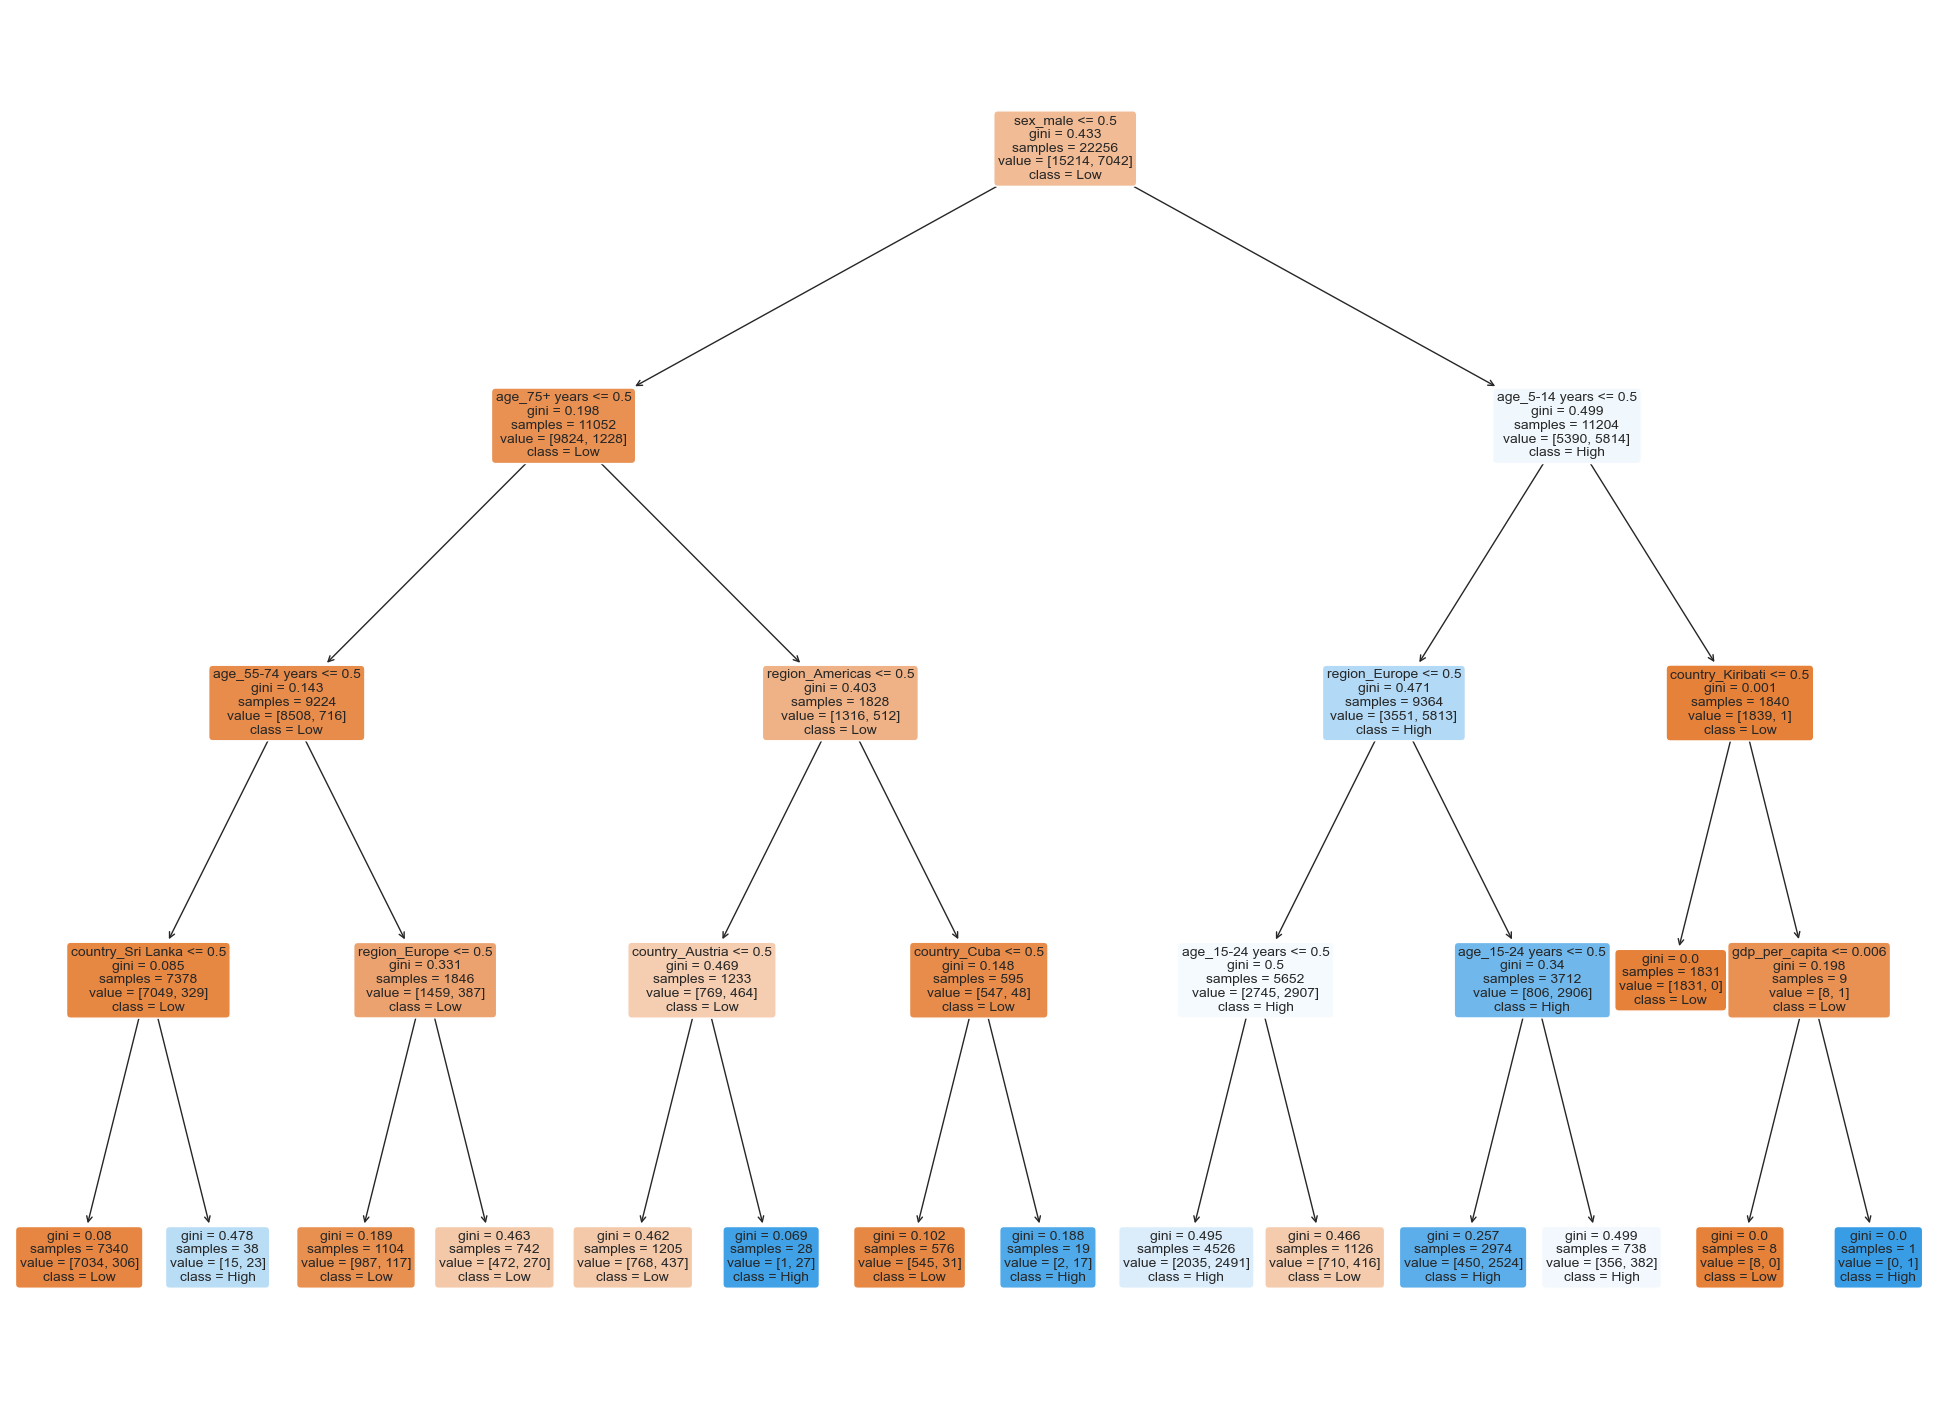

In [40]:
# Plot the trained Decision Tree
from sklearn.tree import plot_tree

f = plt.figure(figsize=(25,18))
plot_tree(dectree_4train, feature_names=train_SuicideData.columns, filled=True, rounded=True,class_names=["Low","High"],fontsize= 10)
# Split by sex first, age then region

## Visualize the top 10 most important features

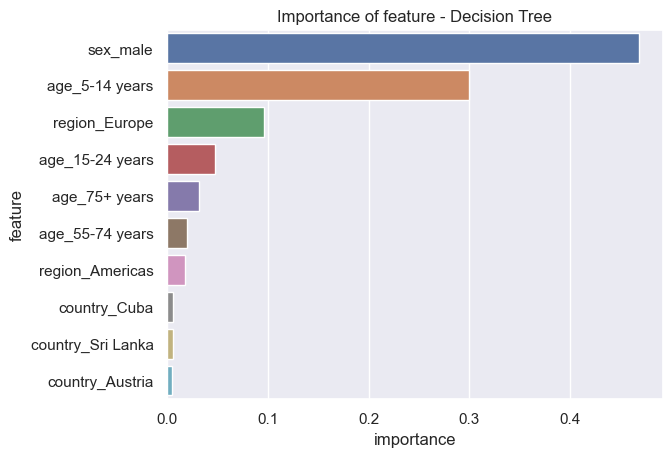

In [41]:
importance_df = pd.DataFrame({'feature': train_SuicideData.columns, 'importance': dectree_4train.feature_importances_}).sort_values(by='importance', ascending=False)

sb.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Importance of feature - Decision Tree');

Most important factors are sex-female, age-5-14 then region-Europe in categorizing the suicide risk.

Text(0.5, 20.049999999999997, 'Predicted')

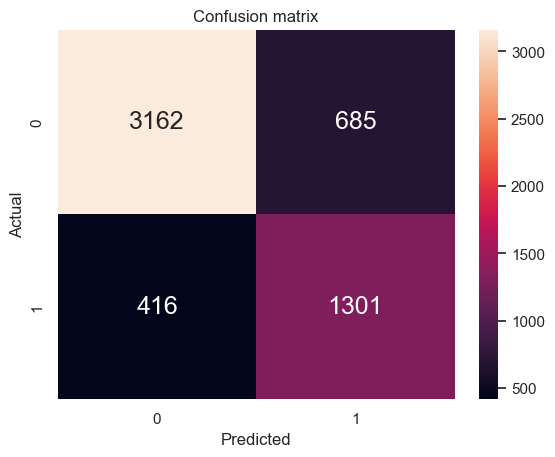

In [42]:
from sklearn.metrics import accuracy_score, confusion_matrix

SuicideRisk_4_pred = dectree_4train.predict(test_SuicideData)

# Plot the basic uni-variate figures
# Train on left, Test on right
sb.heatmap(confusion_matrix(test_SuicideRisk, SuicideRisk_4_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [43]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    TN = cm[0][0]
    FP = cm[0][1]
    FN = cm[1][0]
    TP = cm[1][1]
    total_positive = TP + FN
    total_negative = TN + FP
    tp_rate = TP / total_positive
    fp_rate = FP / total_negative
    print('True positive = ', tp_rate)
    print('False positive = ', fp_rate)

In [44]:
# Print the Classification Accuracy depth 4

print("Train Classification Accuracy(against test data) \t:", dectree_4train.score(test_SuicideData, test_SuicideRisk))
# Print T/F postive rate
print_confusion_matrix(test_SuicideRisk, SuicideRisk_4_pred)

Train Classification Accuracy(against test data) 	: 0.8021207764198418
True positive =  0.7577169481654048
False positive =  0.178060826618144


We can see that the classification tree is decently accurate at predicting suicide risk. However, it may not be good enough as almost one fifth are false negative, that is take (1 - True Postive Rate). A person of suicidal risk has around a 20% chance to be miscategorized to be of low risk, resulting in possibly a life lost. Thus, false negative rates/ true positive rates have to be low to ensure the aid does go to them. <br>

False positive can be lower to minimize the waste of resources, but it is NOT more important than a person of suicidal risk missing out on aid.

# Random Forest Classification
We use the same train and test data for classfication tree above

## Hyperparameters 

100 trees - enough trees to reduce bias, as more trees does not lead to overfitting(due to bootstrap function)

In [45]:
# Random forest classification
from sklearn.ensemble import RandomForestClassifier


# Instantiate model with 200 decision trees
rftrain = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Train the model on training data
# train_SuicideData, test_SuicideData, train_SuicideRisk, test_SuicideRisk
rftrain.fit(train_SuicideData, train_SuicideRisk.values.ravel())

RandomForestClassifier(random_state=42)

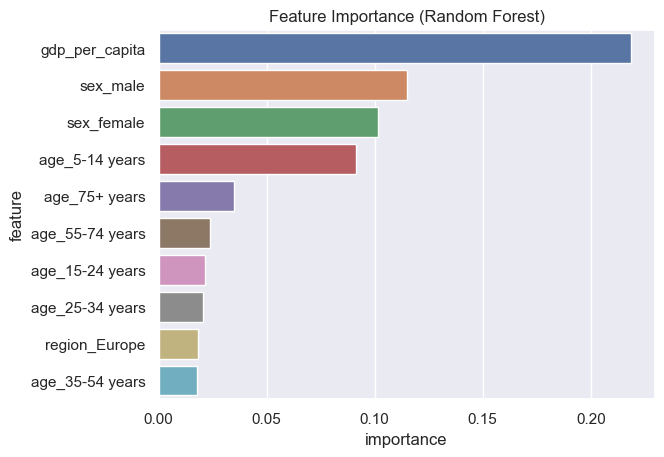

In [46]:
# find most important variables(again)
importance_df = pd.DataFrame({
    'feature': train_SuicideData.columns,
    'importance': rftrain.feature_importances_
}).sort_values(by='importance', ascending=False)

# Visualize the feature importance
sb.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Feature Importance (Random Forest)');

## gdp_per_capita is a new imporantant var popping out!

gdp_per_capita is a new important numerical variable! Was not in the top 10 before in classification tree. Money does matter.
From EDA, we also could not observe relation between suicide rates and gdppercapita.

Important variables: gdppercapita, sex, age, region-europe.

In [1]:
# we initialised 1000 decision trees in the random forest
# lets take a look at a random(first) tree
plt.figure(figsize=(15, 10))
plot_tree(rftrain.estimators_[0], feature_names=train_SuicideData.columns, max_depth=2, filled=True, class_names = ["Low","High"], fontsize=10);

NameError: name 'plt' is not defined

In [ ]:
# and another tree
plt.figure(figsize=(15, 10))
plot_tree(rftrain.estimators_[5], feature_names=train_SuicideData.columns, max_depth=2, filled=True, class_names = ["Low","High"], fontsize=10);

We see that each decision tree is using different features to split the samples. This is because the dataset was built from various sub-samples of the dataset (bootstrap feature). This "randomness" helps control overfitting.

Text(0.5, 20.049999999999997, 'Predicted')

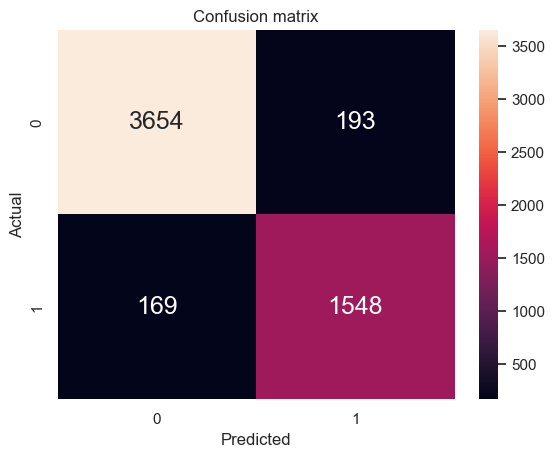

In [49]:
SuicideRiskRF_test_pred = rftrain.predict(test_SuicideData)

# Plot the basic uni-variate figures
sb.heatmap(confusion_matrix(test_SuicideRisk, SuicideRiskRF_test_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})

plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [50]:
# Print the Classification Accuracy 

print("Classification Accuracy(train model against test data) \t:", rftrain.score(test_SuicideData, test_SuicideRisk))
# Print T/F postive rate
print_confusion_matrix(test_SuicideRisk, SuicideRiskRF_test_pred)


Classification Accuracy(train model against test data) 	: 0.9349388928828181
True positive =  0.9015725101921956
False positive =  0.0501689628281778


# Logistics Regression Model (NOT USED), IGNORE

Here we use the same dataset.



In [ ]:
# import the class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16, max_iter=1000)

# fit the model with data
logreg.fit(train_SuicideData, train_SuicideRisk.values.ravel())

SuicideRiskLR_pred = logreg.predict(test_SuicideData)

In [ ]:
sb.heatmap(confusion_matrix(test_SuicideRisk, SuicideRiskLR_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("Train Classification Accuracy(against test data) \t:", logreg.score(test_SuicideData, test_SuicideRisk))
print_confusion_matrix(test_SuicideRisk, SuicideRiskLR_pred)

# XGBOOST Model

XGBoost is short for extreme gradient boosting. This method is based on decision trees and improves on other methods such as random forest and gradient boost. It works well with large, complicated datasets by using various optimization methods.<br>

Each subsequent tree learns from the previous trees and is not assigned equal weight, unlike how Random Forest works.<br>

## Hyperparameters 

https://xgboost.readthedocs.io/en/stable/parameter.html many many parameters

In [53]:
import xgboost as xgb
from xgboost import XGBClassifier
# Create regression matrices

XGBmodel = XGBClassifier(n_estimators=100, objective='binary:logistic', tree_method='hist', eta=0.3, max_depth=3)
XGBmodel.fit(train_SuicideData, train_SuicideRisk)

SuicideRiskXGB_pred = XGBmodel.predict(test_SuicideData)

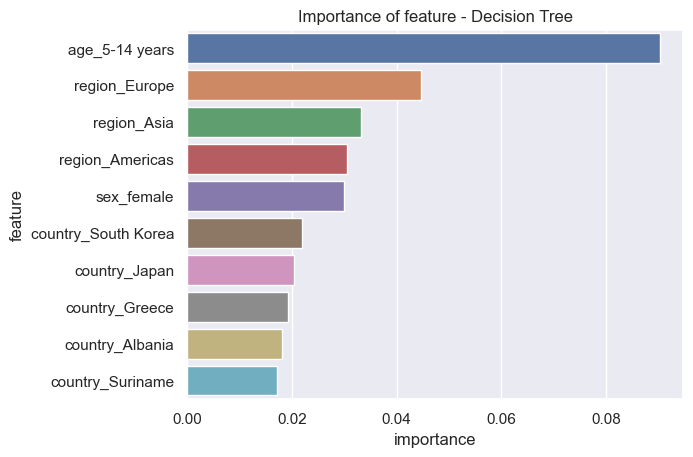

In [54]:
importance_df = pd.DataFrame({'feature': train_SuicideData.columns, 'importance': XGBmodel.feature_importances_}).sort_values(by='importance', ascending=False)

sb.barplot(data=importance_df.head(10), x='importance', y='feature')
plt.title('Importance of feature - Decision Tree');

Train Classification Accuracy(against test data) 	: 0.9069015097052481
True positive =  0.8514851485148515
False positive =  0.06836495970886405


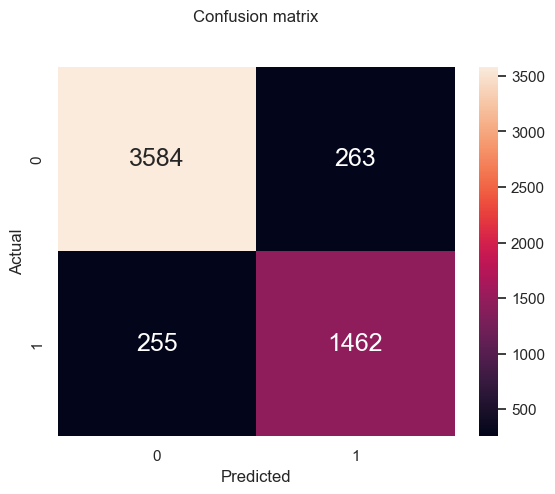

In [55]:
sb.heatmap(confusion_matrix(test_SuicideRisk, SuicideRiskXGB_pred), 
           annot = True, fmt=".0f", annot_kws={"size": 18})
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual')
plt.xlabel('Predicted')

print("Train Classification Accuracy(against test data) \t:", XGBmodel.score(test_SuicideData, test_SuicideRisk))
print_confusion_matrix(test_SuicideRisk, SuicideRiskXGB_pred)

In [56]:
# for path var in loading graphviz - if graph doesnt load change directory.
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz/bin'

<Axes: >

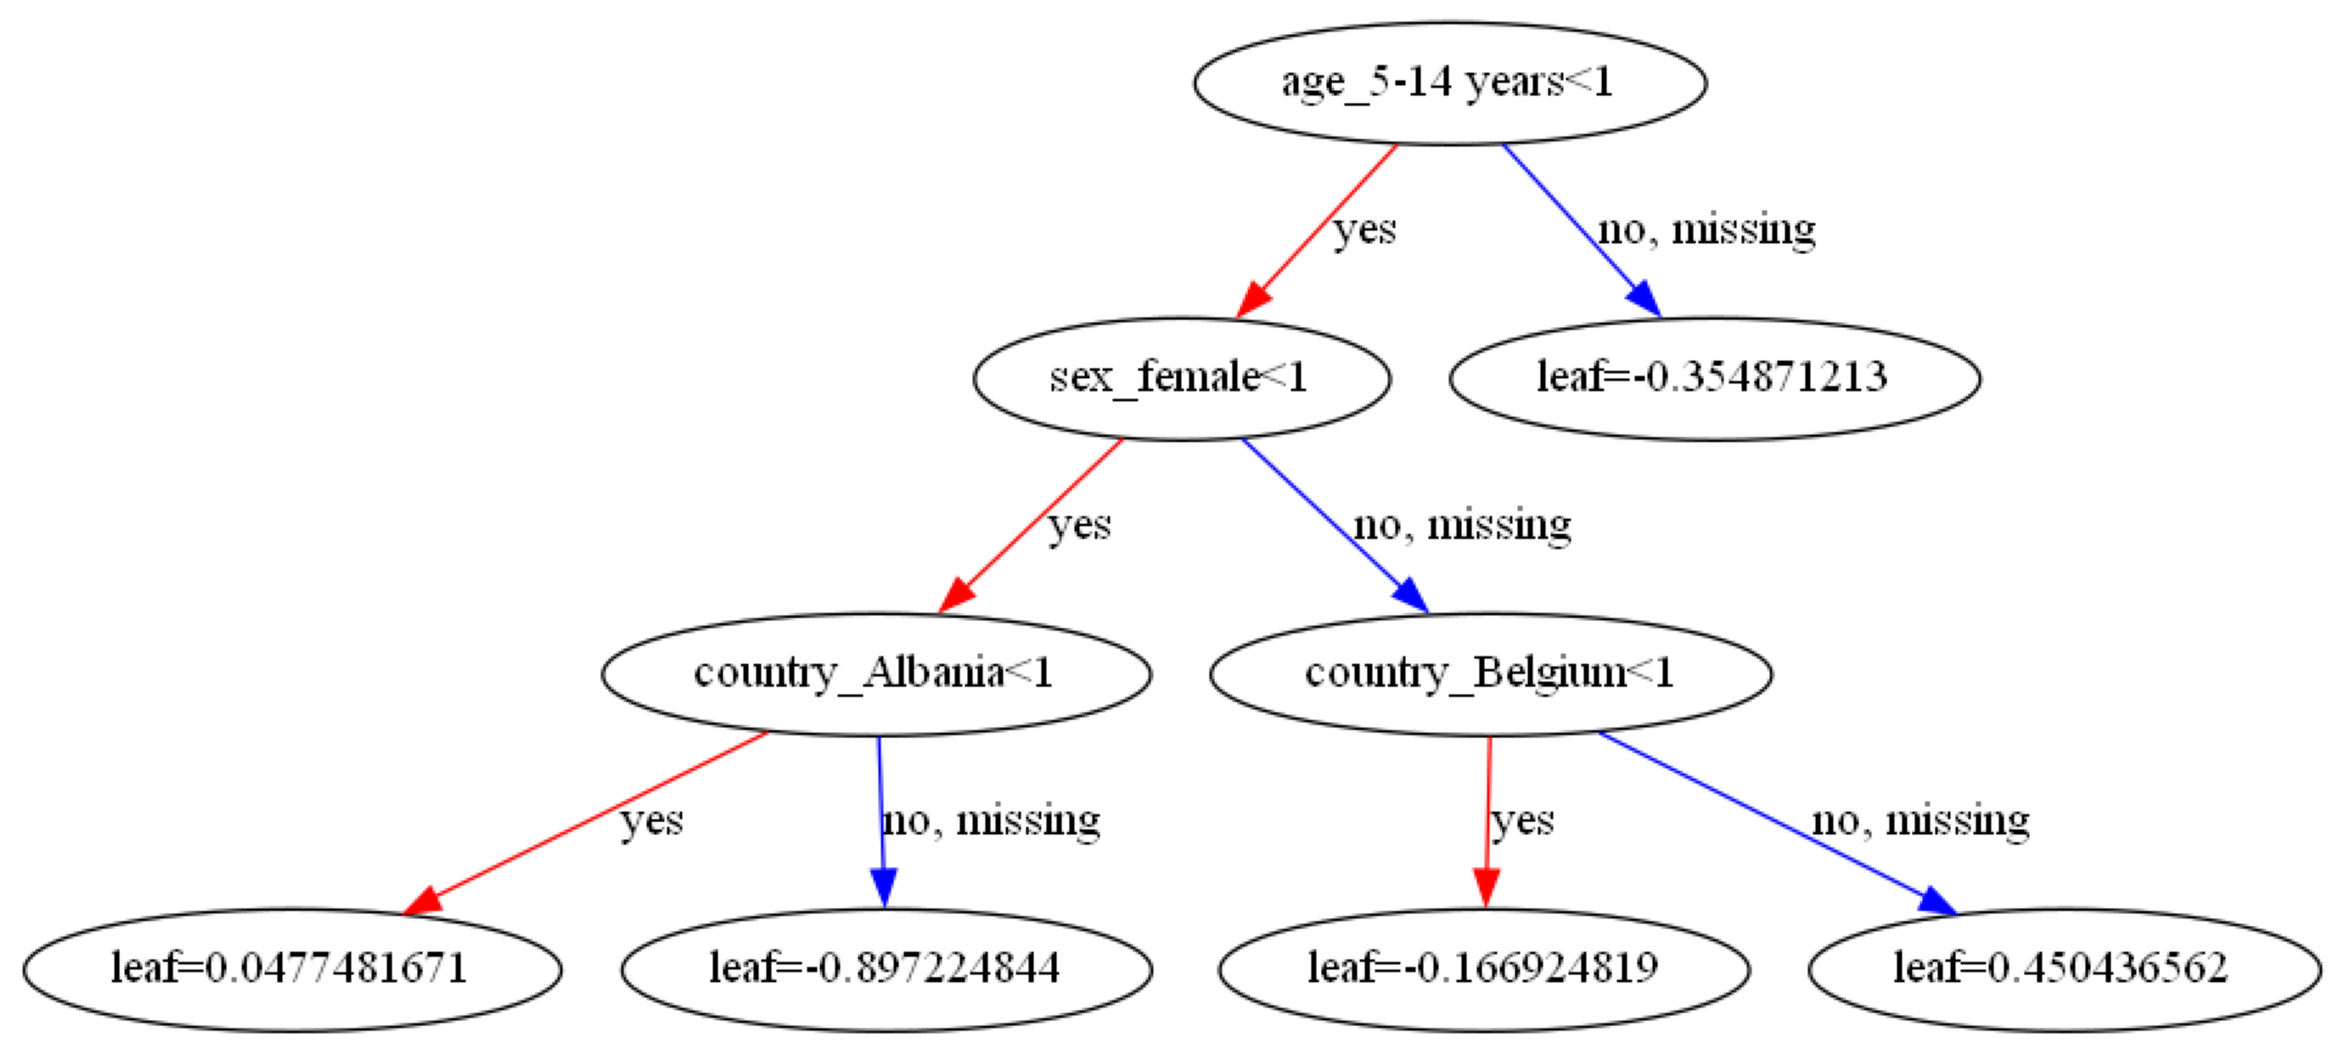

In [57]:
from xgboost import plot_tree
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(XGBmodel,num_trees=4,ax=ax)

<Axes: >

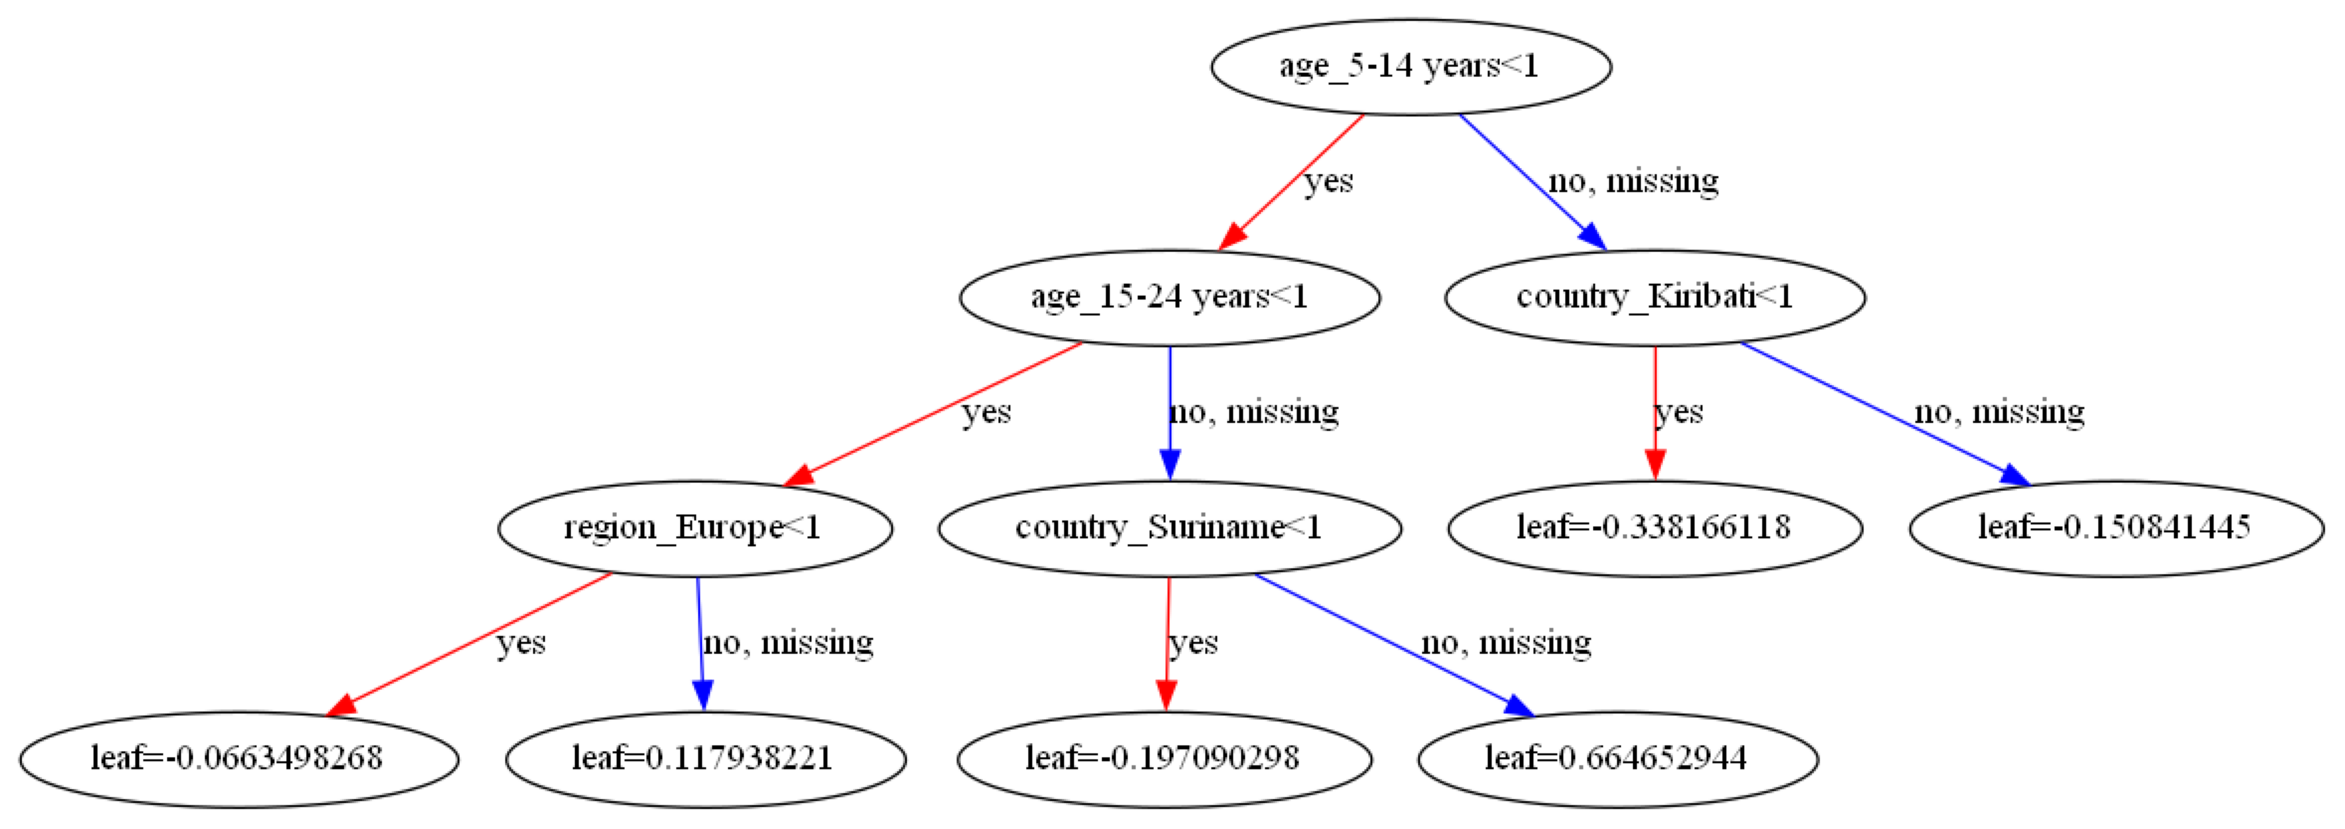

In [58]:
fig, ax = plt.subplots(figsize=(30, 30))
plot_tree(XGBmodel,num_trees=5,ax=ax)

# Comparison between all

DecTree:<br>
Classification Accuracy 	: 0.8021207764198418<br>
True positive =  0.7577169481654048<br>
False positive =  0.178060826618144<br>

RandomForest:<br>
Classification Accuracy 	: 0.9349388928828181<br>
True positive =  0.9495710943592409<br>
False positive =  0.0978450786255096<br>

XGBoost:<br>
Classification Accuracy 	: 0.9069015097052481<br>
True positive =  0.8514851485148515<br>
False positive =  0.06836495970886405<br>